In [631]:
%store -r Final_Data_Set_Nor
%store -r EN_Des

import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from NDE_Time_Series_Problem import fashion_scatter

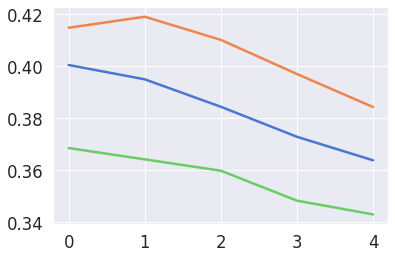

In [567]:
sector_rev_3 = np.array([0.,0.,0.,0.,0.])
sector_rev_2 = np.array([0.,0.,0.,0.,0.])
sector_rev_5 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
for i in Final_Data_Set_Nor.items():
    ID, data = i
    if data['Sector'][1:-1] == "325412":
        sector_rev_3 += np.array(data['Revenue'])
        n += 1
    elif data['Sector'][1:-1] == "2111":
        sector_rev_2 += np.array(data['Revenue'])
        m += 1
    elif data['Sector'][1:-1] == "511210":
        sector_rev_5 += np.array(data['Revenue'])
        p += 1
    
        
sector_rev_3 = sector_rev_3/n
sector_rev_2 = sector_rev_2/m
sector_rev_5 = sector_rev_5/p
plt.plot(range(len(sector_rev_3)),sector_rev_3)
plt.plot(range(len(sector_rev_2)),sector_rev_2)
plt.plot(range(len(sector_rev_5)),sector_rev_5)
plt.show()

In [568]:
def build_borrower_sector_graph(Data_Set):
    
    n_borrowers = len(Data_Set.keys())
    
    sector_list = set()
    for i in Data_Set.items():
        ID,data = i
        sector_list.add(data['Sector'])
    print(sector_list)
    sector_list = list(sector_list)
    n_sectors = len(sector_list)
    
    b_s_dst = []
    for i in Data_Set.items():
        ID,data = i
        b_s_dst.append(sector_list.index(data['Sector']))
    
    b_s_src = T.arange(n_borrowers)
    b_s_dst = T.tensor(b_s_dst)
    
    
    data_dict = {
    ('R&E', 'fin1', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE&TDE', 'fin2', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Description', 'text', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('R', 'R_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('E', 'E_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE', 'NDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('TDE', 'TDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Att_Description', 'text_att', 'Description' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('sector', 'belongs to', 'borrower'): (b_s_dst, b_s_src),
    ('Factor', 'effect', 'sector'): (T.tensor([0,1,2]), T.tensor([0,1,2]))
    }

    return dgl.heterograph(data_dict),n_borrowers,n_sectors, b_s_dst

G, n_borrowers, n_sectors, sector_list = build_borrower_sector_graph(Final_Data_Set_Nor)


{'"325412"', '"2111"', '"511210"'}


In [569]:
def Loss_Function(embeddings, target_centers, centers):
    
    next_target = []
    for i in range(len(embeddings)):

        cluster = target_centers[i]
        
        if len(centers) != 1: 
            dist = []
            C = []
            for m in centers:
                d = np.square(embeddings.detach().numpy()[i] - m.detach().numpy()).mean()
                dist.append(d)
                C.append(m)
                
            
            tup = list(zip(dist,C))
            lst = len(tup) 
            for i in range(0, lst): 

                for j in range(0, lst-i-1): 
                    if (tup[j][0] > tup[j + 1][0]): 
                        temp = tup[j] 
                        tup[j]= tup[j + 1] 
                        tup[j + 1]= temp
            
            next_c = tup[1][1]
        else:
            next_c = centers[0]
            
        
        next_target.append(next_c.detach().numpy())
    
    next_target = T.tensor(next_target)
    
    b = T.sqrt(T.sum((embeddings - next_target)**2,1))
    a = T.sqrt(T.sum((embeddings - target_centers)**2,1))
    
#     a = a/T.max(a)
#     b = b/T.max(b)
    
#     print("a ", T.sum(a))
#     print("b ", T.sum(b),'\n')
    
    return T.sum((a))            #T.sum((-b))                #/T.max(T.sum(a),T.sum(b))
    

In [570]:
class RGCN(nn.Module):
    def __init__(self, in_RE, out_RE, in_NT, out_NT, in_Des, out_Des, in_sector, out_sector, in_borrower, out_borrower, L1_names, L2_names, L3_names, L4_names, L5_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_sector, out_sector, 'mean', norm = None, activation = None, bias = False) for rel in L1_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_RE, out_RE, 'mean', norm = None, activation = None, bias = False) for rel in L2_names}, aggregate='sum')
        self.conv3 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_NT, out_NT, 'mean', norm = None, activation = None, bias = False) for rel in L3_names}, aggregate='sum')
        self.conv4 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_Des, out_Des, 'mean', norm = None, activation = None, bias = False) for rel in L4_names}, aggregate='sum')
        self.conv5 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_borrower, out_borrower, 'none', activation = None, bias = False) for rel in L5_names}, aggregate='sum')

    def forward(self, graph, inputs):
        sector_inputs = {'Factor' : inputs['Factor'], 'sector' : inputs['sector'], 'borrower' : inputs['borrower']}
        h_sector = self.conv1(graph, sector_inputs)
        h_sector = {k: F.leaky_relu(v) for k, v in h_sector.items()}
        #print("Sector Shape ", h_sector['sector'].size())
        
        RE_inputs = {'R' : inputs['R'], 'E' : inputs['E'], 'R&E' : inputs['R&E'], 'borrower' : inputs['borrower']}
        h_RE = self.conv2(graph, RE_inputs)
        h_RE = {k: F.leaky_relu(v) for k, v in h_RE.items()}
        #print("R&E Shape ", h_RE['R&E'].size())
        
        NT_inputs = {'NDE' : inputs['NDE'], 'TDE' : inputs['TDE'], 'NDE&TDE' : inputs['NDE&TDE'], 'borrower' : inputs['borrower']}
        h_NT = self.conv3(graph, NT_inputs)
        h_NT = {k: F.leaky_relu(v) for k, v in h_NT.items()}
        #print("NDE&TDE Shape ", h_NT['NDE&TDE'].size())
        
        Des_inputs = {'Description' : inputs['Description'], 'Att_Description' : inputs['Att_Description'], 'borrower' : inputs['dummy_borrower']}
        h_Des = self.conv4(graph, Des_inputs)
        h_Des = {k: F.leaky_relu(v) for k, v in h_Des.items()}
        #print("Description Shape ", h_Des['Description'].size())
        
        borrower_inputs = {'sector' : h_sector['sector'], 'borrower' : inputs['borrower'], 'R&E' : h_RE['R&E'], 'NDE&TDE' : h_NT['NDE&TDE'], 'Description' : h_Des['Description']}
        h_borrower = self.conv5(graph, borrower_inputs)
        
        return h_borrower
    


In [627]:
model = RGCN(5,5,5,5,768,5,5,5,5,5, ['belongs to','effect'],['R_att','E_att','fin1'],['NDE_att','TDE_att','fin2'],['text_att','text'],['belongs to','text','fin1','fin2'])

for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = [data['Revenue']]
    E_Att = [data['EBITDA']]
    NDE_Att = [data['NDE']]
    TDE_Att = [data['TDE']]
    Des_Att = data['Description Embedding']
    break
    
for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.cat((T.tensor([data['Revenue']]),T.tensor(R_Att)),0)
    E_Att = T.cat((T.tensor([data['EBITDA']]),T.tensor(E_Att)),0)
    NDE_Att = T.cat((T.tensor([data['NDE']]),T.tensor(NDE_Att)),0)
    TDE_Att = T.cat((T.tensor([data['TDE']]),T.tensor(TDE_Att)),0)
    Des_Att = T.cat((T.tensor(data['Description Embedding']),T.tensor(Des_Att)),0)

    
G.nodes['borrower'].data['f'] = T.zeros(n_borrowers,5)
G.nodes['R'].data['f'] = R_Att[1:]
G.nodes['E'].data['f'] = E_Att[1:]
G.nodes['R&E'].data['f'] = T.zeros(n_borrowers,5)
G.nodes['NDE'].data['f'] = NDE_Att[1:]
G.nodes['TDE'].data['f'] = TDE_Att[1:]
G.nodes['NDE&TDE'].data['f'] = T.zeros(n_borrowers,5)
G.nodes['Att_Description'].data['f'] = Des_Att[1:]
G.nodes['Description'].data['f'] = T.zeros(n_borrowers,768)
G.nodes['Factor'].data['f'] = T.zeros(n_sectors,5)
G.nodes['sector'].data['f'] = T.tensor([[1.,0.,0.,0.,0.],[0.,0.,1.,0.,0.],[0.,0.,0.,0.,1.]])

/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launc

Avg Node Cluster Distance of Cluster  0  is  13.295483
Cluster  0  Center  [13.966869 -9.466473]
Avg Node Cluster Distance of Cluster  1  is  14.092395
Cluster  1  Center  [-13.598601   -4.5059466]
Avg Node Cluster Distance of Cluster  2  is  11.350222
Cluster  2  Center  [-1.3363779 20.572565 ]
Cluster Distance between  0  and others 
1   28.00825
2   33.71251
Cluster Distance between  1  and others 
0   28.00825
2   27.915836
Cluster Distance between  2  and others 
0   33.71251
1   27.915836


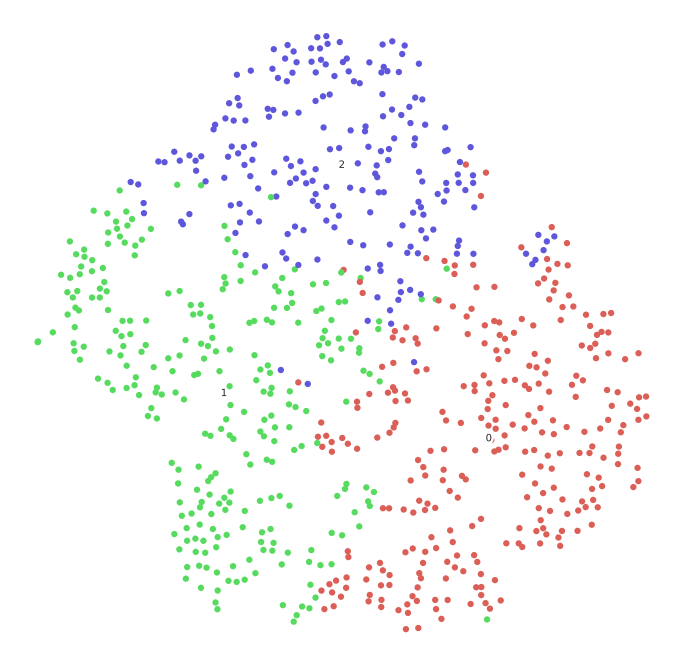

In [628]:
borrower_feats = G.nodes['borrower'].data['f']
sector_feats = G.nodes['sector'].data['f']
R_feats = G.nodes['R'].data['f']
E_feats = G.nodes['E'].data['f']
RE_feats = G.nodes['R&E'].data['f']
NDE_feats = G.nodes['NDE'].data['f']
TDE_feats = G.nodes['TDE'].data['f']
NT_feats = G.nodes['NDE&TDE'].data['f']
Des_feats = G.nodes['Description'].data['f']
Des_att_feats = G.nodes['Att_Description'].data['f']
factor_feats = G.nodes['Factor'].data['f']
dummy_borrower_feats = T.zeros(n_borrowers,768)

node_features = {'borrower':borrower_feats,'sector':sector_feats,'R':R_feats,'E':E_feats,'R&E':RE_feats,'NDE':NDE_feats,
                 'Description':Des_feats,'Att_Description':Des_att_feats,'TDE':TDE_feats,'NDE&TDE': NT_feats,
                 'Factor':factor_feats,'dummy_borrower' : dummy_borrower_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 3
Loss = []
epochs = 100
index = [i for i, n in enumerate(sector_list) if n == 0]
index2 = [i for i, n in enumerate(sector_list) if n == 1]
index3 = [i for i, n in enumerate(sector_list) if n == 2]

for epoch in range(epochs):
    
    model.train()
    logits = model(G, node_features)
    
    X = logits['borrower'].detach().numpy()
    Des
    #X = X[index]
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
    centers = kmeans.cluster_centers_
    
    target_centers = []
    for i in X:
        l = []
        for j in centers:
            mse = np.square(i - j).mean()
            l.append(mse)
        
        target_centers.append(l.index(min(l)))
        
        
    centers = T.tensor(centers)
    target_centers = centers[T.tensor(target_centers)]
    
    if epoch == 0:
        fashion_tsne = TSNE(random_state=123).fit_transform(X)
        fashion_scatter(fashion_tsne, kmeans.labels_)
        
    #loss = F.mse_loss(logits['borrower'], target_centers)
    score = Loss_Function(logits['borrower'], target_centers, centers)
    Loss.append(score.tolist())

    
    opt.zero_grad()
    score.backward()
    opt.step()



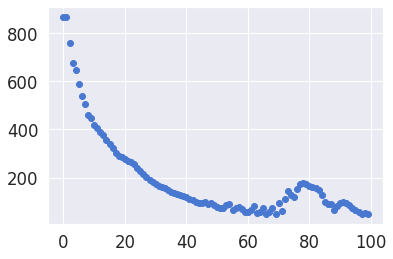

Avg Node Cluster Distance of Cluster  0  is  12.249649
Cluster  0  Center  [-24.221872  13.538295]
Avg Node Cluster Distance of Cluster  1  is  12.450022
Cluster  1  Center  [  0.06457341 -12.80399   ]
Avg Node Cluster Distance of Cluster  2  is  10.165535
Cluster  2  Center  [32.99055   5.496377]
Cluster Distance between  0  and others 
1   35.829422
2   57.774857
Cluster Distance between  1  and others 
0   35.829422
2   37.669926
Cluster Distance between  2  and others 
0   57.774857
1   37.669926


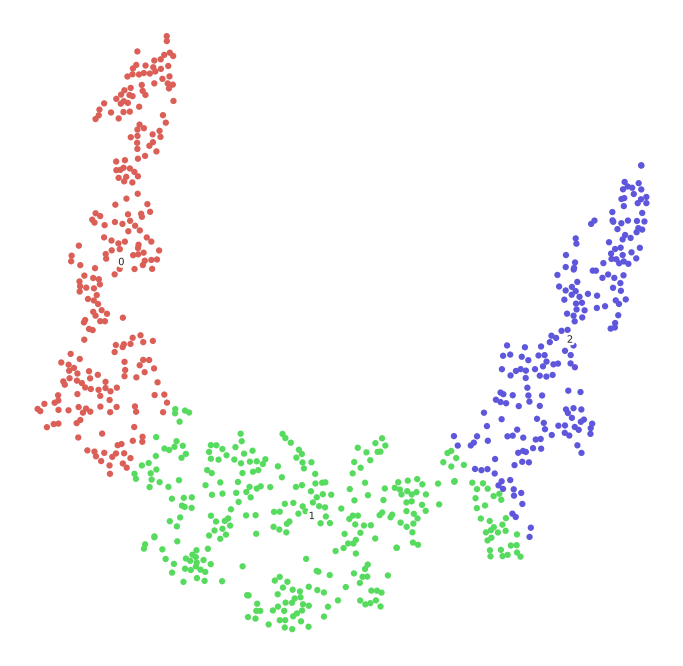

In [629]:
plt.scatter(list(range(len(Loss))),Loss)
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X)
fashion_scatter(fashion_tsne, kmeans.labels_)

In [633]:
cluster_1 = np.where(kmeans.labels_ == 0)[0]
cluster_2 = np.where(kmeans.labels_ == 1)[0]
cluster_3 = np.where(kmeans.labels_ == 2)[0]

    
n = 0
N = 0
print("Cluster 1")
for i in Final_Data_Set_Nor.items():
    ID,data = i
    
    if (n in cluster_1) and (N <= 5):
        print(data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'],EN_Des[ID]['Description'],"\n")
        N += 1
    elif N > 5:
        print("\n")
        break
    n += 1
        
m = 0
M = 0
print("Cluster 2")
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if (m in cluster_2) and (M <= 5):
        print(data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'],EN_Des[ID]['Description'],"\n")
        M += 1
    elif M > 5:
        print("\n")
        break
    m += 1
        
p = 0
P = 0
print("Cluster 3")
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if p in cluster_3 and P <= 5:
        print("Cluster 3",data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'],EN_Des[ID]['Description'],"\n")
        P += 1
    elif P > 5:
        print("\n")
        break

    p += 1

Cluster 1
[0.5, 0.5, 0.4, 0.3, 0.3] [0.5, 0.5, 0.3, 0.3, 0.3] [0, 0.2, 0, 0, 0] [0.06, 0.32, 0.65, 0.16, 0.18] Rosehill Resources, Inc. operates as an independent oil and natural gas compan 

[0.7, 0.7, 0.7, 0.7, 0.7] [0.7, 0.6, 0.6, 0.5, 0.5] [1.0, 1.0, 0.6, 0.1, 0] [0.61, 0.53, 0.45, 0.04, 0.05] Cephalon, Inc., a biopharmaceutical company, engages in the discovery, development, and commercialization of products for central nervous system (CNS) disorders, pain, oncology, inflammatory disease, and regenerative medicine. In addition to conducting an active research and development program, the company markets various branded and generic products. It sells approximately 150 products in approximately 100 countrie 

[0.1, 0.1, 0.1, 0.1, 0.1] [0.1, 0.1, 0, 0, 0] [0.0, 0, 0, 1.0, 0] [0, 0, 0, 0, 0.89] Carpatsky Petroleum, Inc (Carpatsky or the Company) is organized under the laws of the Province of Alberta, Canada. The Companys principal business is to participate in the development, produc

"325412" [0.5, 0.5, 0.5, 0.4, 0.4] [0.1, 0.3, 0.1, 0, 0] [0, 1.0, 0, 1.0, 1.0] [0, 0, 0, 0, 0]
"325412" [0.5, 0.5, 0.7, 0.5, 0.5] [0, 0, 0.6, 0, 0] [0, 0, 0, 0, 0] [0.87, 0.71, 0.86, 0, 0]
"325412" [0.2, 0.2, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0] [0, 0, 0, 0.0, 0] [1.0, 0.99, 0.97, 0.85, 1.0]
"325412" [0.2, 0.2, 0.2, 0.2, 0.2] [0, 0, 0, 0, 0] [0, 0, 0, 0, 0] [0, 0, 0, 0, 0.15]
"325412" [0.4, 0.4, 0.4, 0.3, 0.3] [0.3, 0.3, 0.3, 0.1, 0.1] [0, 0, 0, 1.0, 0.4] [0.95, 0.94, 0.93, 0.88, 0.88]
"325412" [0.4, 0.5, 0.5, 0.5, 0.5] [0, 0.4, 0.5, 0.4, 0.5] [0, 0, 0, 0, 0] [0, 0, 0, 0, 0]
"325412" [0.1, 0.1, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0] [0, 0, 0, 0, 0] [0, 0, 0, 0, 0]
"325412" [0.1, 0.1, 0.1, 0.1, 0.1] [0, 0.1, 0.1, 0, 0] [0, 0, 0, 1.0, 1.0] [0, 0, 0, 0.88, 0.93]
"325412" [0.7, 0.7, 0.7, 0.7, 0.6] [0.5, 0.5, 0.5, 0.5, 0.5] [0, 0, 0, 0, 1.0] [0.25, 0.05, 0, 0, 0.48]
"325412" [0.1, 0.1, 0.1, 0.1, 0.2] [0, 0, 0, 0, 0] [0, 0.4, 1.0, 0.2, 0] [0.72, 0, 0, 0, 0]
"325412" [0.2, 0.3, 0.3, 0.3, 0.3] [0, 0, 0, 0, 

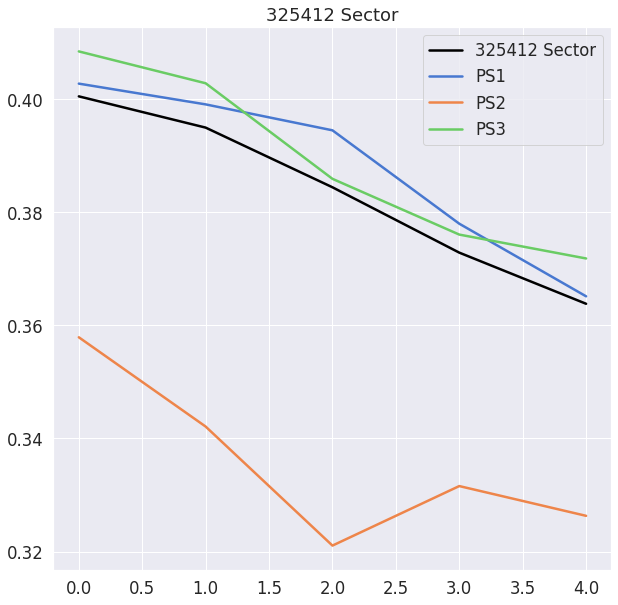

Avg Node Cluster Distance of Cluster  0  is  5.448419
Cluster  0  Center  [-4.618402 -9.014585]
Avg Node Cluster Distance of Cluster  1  is  0.7342882
Cluster  1  Center  [12.587378 15.250791]
Avg Node Cluster Distance of Cluster  2  is  3.5340335
Cluster  2  Center  [6.099868  7.4746466]
Cluster Distance between  0  and others 
1   29.746384
2   19.666622
Cluster Distance between  1  and others 
0   29.746384
2   10.127004
Cluster Distance between  2  and others 
0   19.666622
1   10.127004


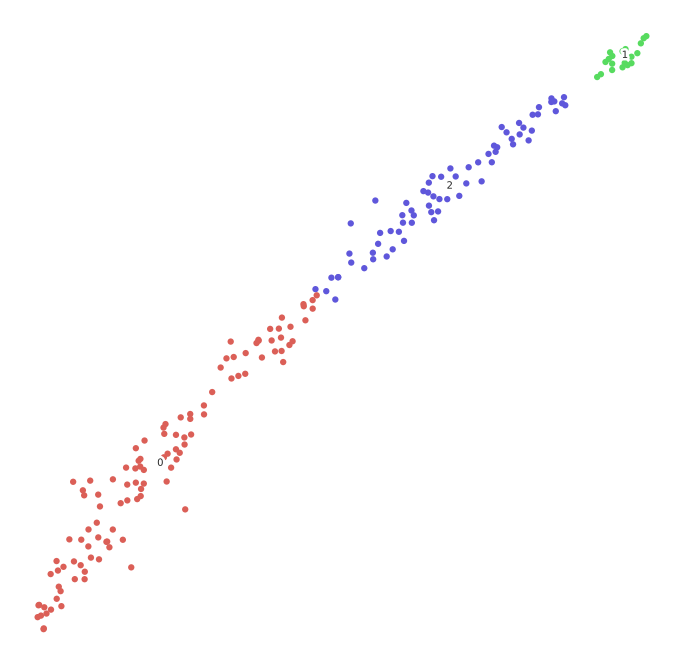

In [599]:
X_1 = logits['borrower'].detach().numpy()[index]
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(X_1)

PS1_1 = []
PS2_1 = []
PS3_1 = []

for i in list(zip(index,kmeans_1.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_1.append(ind)
    elif ps == 1:
        PS2_1.append(ind)
    elif ps == 2:
        PS3_1.append(ind)
        
Psector1_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_1 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_1:
        print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_1 += np.array(data['Revenue'])
        m += 1
    if n in PS2_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector2_rev_1 += np.array(data['Revenue'])
        p += 1
    if n in PS3_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector3_rev_1 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_1 = Psector1_rev_1/m
Psector2_rev_1 = Psector2_rev_1/p
Psector3_rev_1 = Psector3_rev_1/q
print(m,p,q)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_3)),sector_rev_3,'k')
ps1, = plt.plot(range(len(Psector1_rev_1)),Psector1_rev_1)
ps2, = plt.plot(range(len(Psector2_rev_1)),Psector2_rev_1)
ps3, = plt.plot(range(len(Psector3_rev_1)),Psector3_rev_1)
plt.legend([S,ps1,ps2,ps3],['325412 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("325412 Sector")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_1)
fashion_scatter(fashion_tsne, kmeans_1.labels_)

99 69 68 756


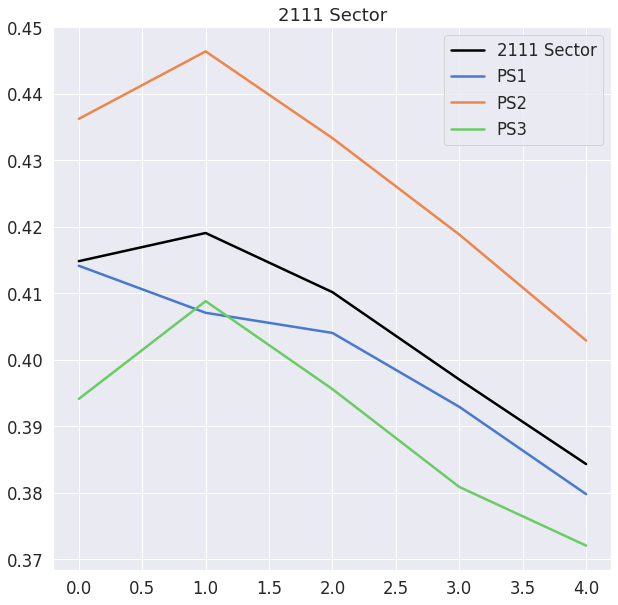

Avg Node Cluster Distance of Cluster  0  is  2.532898
Cluster  0  Center  [ 14.042209 -16.797161]
Avg Node Cluster Distance of Cluster  1  is  2.8500204
Cluster  1  Center  [-11.316516  13.75997 ]
Avg Node Cluster Distance of Cluster  2  is  7.3553843
Cluster  2  Center  [ 1.0188017 -2.1053002]
Cluster Distance between  0  and others 
1   39.70898
2   19.633133
Cluster Distance between  1  and others 
0   39.70898
2   20.09644
Cluster Distance between  2  and others 
0   19.633133
1   20.09644


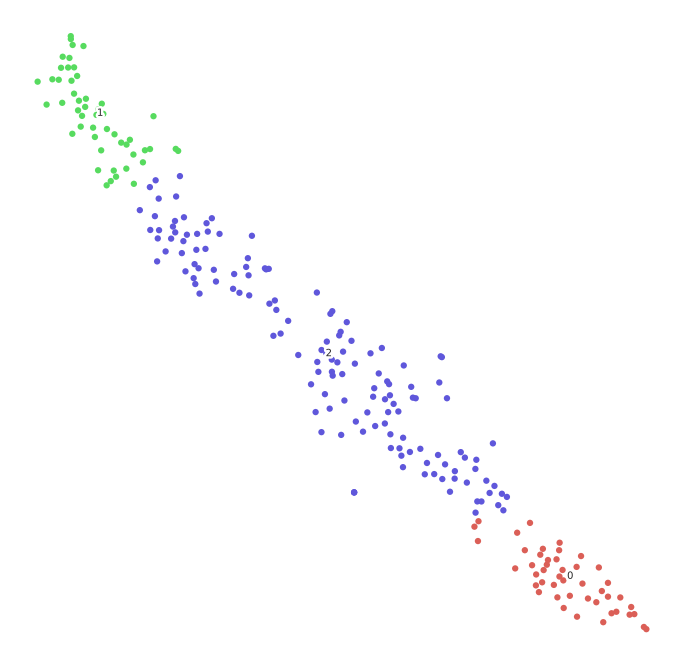

In [575]:
X_2 = logits['borrower'].detach().numpy()[index2]
kmeans_2 = KMeans(n_clusters=3, random_state=0).fit(X_2)

PS1_2 = []
PS2_2 = []
PS3_2 = []

for i in list(zip(index2,kmeans.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_2.append(ind)
    elif ps == 1:
        PS2_2.append(ind)
    elif ps == 2:
        PS3_2.append(ind)
        
Psector1_rev_2 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_2 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_2 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_2:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_2 += np.array(data['Revenue'])
        m += 1
    if n in PS2_2:
        Psector2_rev_2 += np.array(data['Revenue'])
        p += 1
    if n in PS3_2:
        Psector3_rev_2 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_2 = Psector1_rev_2/m
Psector2_rev_2 = Psector2_rev_2/p
Psector3_rev_2 = Psector3_rev_2/q
print(m,p,q,n)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_2)),sector_rev_2,'k')
ps1, = plt.plot(range(len(Psector1_rev_2)),Psector1_rev_2)
ps2, = plt.plot(range(len(Psector2_rev_2)),Psector2_rev_2)
ps3, = plt.plot(range(len(Psector3_rev_2)),Psector3_rev_2)
plt.legend([S,ps1,ps2,ps3],['2111 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("2111 Sector")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_2)
fashion_scatter(fashion_tsne, kmeans_2.labels_)

131 95 95


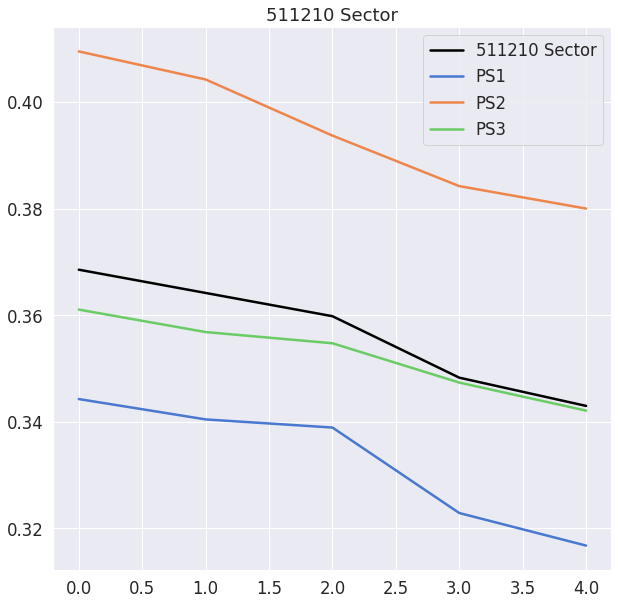

Avg Node Cluster Distance of Cluster  0  is  5.3806076
Cluster  0  Center  [-21.92217   -8.851662]
Avg Node Cluster Distance of Cluster  1  is  9.741643
Cluster  1  Center  [4.1065516 2.960783 ]
Avg Node Cluster Distance of Cluster  2  is  2.274732
Cluster  2  Center  [26.122675 11.092748]
Cluster Distance between  0  and others 
1   28.583706
2   52.020058
Cluster Distance between  1  and others 
0   28.583706
2   23.46995
Cluster Distance between  2  and others 
0   52.020058
1   23.46995


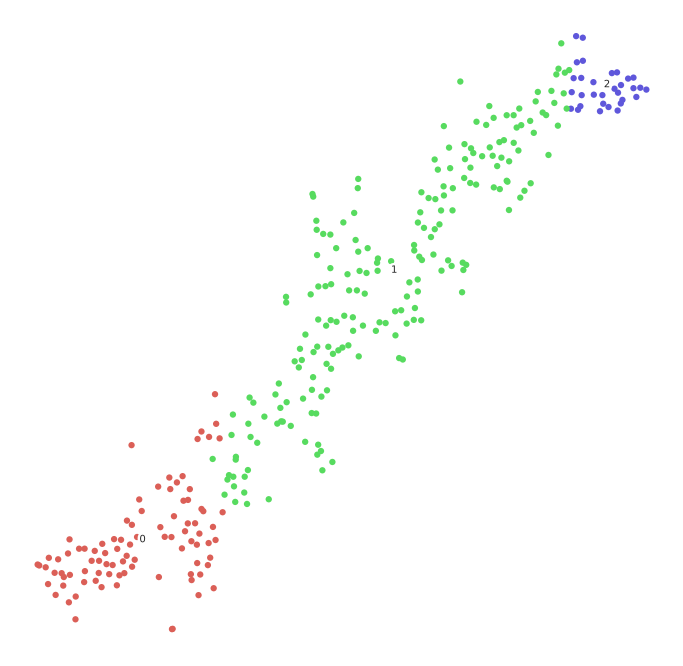

In [576]:
X_3 = logits['borrower'].detach().numpy()[index3]
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(X_3)

PS1_3 = []
PS2_3 = []
PS3_3 = []

for i in list(zip(index3,kmeans.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_3.append(ind)
    elif ps == 1:
        PS2_3.append(ind)
    elif ps == 2:
        PS3_3.append(ind)
        
Psector1_rev_3 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_3 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_3 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_3:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_3 += np.array(data['Revenue'])
        m += 1
    if n in PS2_3:
        Psector2_rev_3 += np.array(data['Revenue'])
        p += 1
    if n in PS3_3:
        Psector3_rev_3 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_3 = Psector1_rev_3/m
Psector2_rev_3 = Psector2_rev_3/p
Psector3_rev_3 = Psector3_rev_3/q
print(m,p,q)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_5)),sector_rev_5,'k')
ps1, = plt.plot(range(len(Psector1_rev_3)),Psector1_rev_3)
ps2, = plt.plot(range(len(Psector2_rev_3)),Psector2_rev_3)
ps3, = plt.plot(range(len(Psector3_rev_3)),Psector3_rev_3)
plt.legend([S,ps1,ps2,ps3],['511210 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("511210 Sector")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_3)
fashion_scatter(fashion_tsne, kmeans_3.labels_)

In [174]:
g = dgl.heterograph({
    ('user', 'follows', 'user') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('user', 'plays', 'game') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('store', 'sells', 'game')  : (T.tensor([0,1,2]),T.tensor([0,1,2]))})

In [189]:
import dgl.nn.pytorch as dglnn
conv = dglnn.HeteroGraphConv({
    'follows' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'plays' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'sells' : dglnn.SAGEConv(3,3, 'mean', norm = None,weight = False, activation = None, bias = False)}, aggregate='sum')

In [191]:
h1 = {'user' : T.rand(g.number_of_nodes('user'), 3), 'game' : T.ones(g.number_of_nodes('game'), 3)}
h11 = {'store' : T.rand(g.number_of_nodes('store'),3), 'game' : T.zeros(g.number_of_nodes('game'), 3)}
print(h1)
h2 = conv(g, h1)
print(h2)

{'user': tensor([[0.2381, 0.8439, 0.3931],
        [0.3619, 0.0391, 0.8795],
        [0.1815, 0.5393, 0.1728]]), 'game': tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])}
{'game': tensor([[0.2381, 0.8439, 0.3931],
        [0.3619, 0.0391, 0.8795],
        [0.1815, 0.5393, 0.1728]]), 'user': tensor([[0.2381, 0.8439, 0.3931],
        [0.3619, 0.0391, 0.8795],
        [0.1815, 0.5393, 0.1728]])}
